# Effect of varying linear-nonlinear subunit parameters

This notebook contains code for Fig. 3 of [Harkin, Shen _et al_. (2021)](https://doi.org/10.1101/2021.03.25.437091).

## Setup

In [114]:
from pylab import *
from numpy import *
from scipy.signal import lfilter

pars = {}
pars['Tfilt'] = 100 # length of filter in ms
pars['dt'] = 0.1 # timestep in ms/step
pars['Tlong']=5001 # length of long injections in ms
pars['range_t'] = np.arange(0, pars['Tlong'], pars['dt'])

def DesignExponentialFilter(pars,tau):
  t = arange(0,pars['Tfilt'],pars['dt'])
  IRF_filter = exp(-t/tau)
  IRF_filter[0]=0
  IRF_filter = IRF_filter*pars['dt']/sum(IRF_filter*pars['dt'])
  return IRF_filter,t


def sigmoid(x):
  y = 1/(1+exp(-x))
  return y

def my_GWN(pars, mu, sig, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  # you can fix the seed of the random number generator so that the results
  # are reliable however, when you want to generate multiple realization
  # make sure that you change the seed for each new realization.
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to sec.
  I_gwn = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_gwn

def plot_trace(pars,Vd,VL,scalebar=False):
  figure()
  plot(pars['range_t'][1000:3000],Vd[1000:3000])
  plot(pars['range_t'][1000:3000],VL[1000:3000])
  plot(pars['range_t'][1000:3000],pars['range_t'][1000:3000]*0,'k--')
  xlabel('time [ms]')
  ylabel('$V_d$ [mV]')
  ylim(-45,25)
  axis('off')
  if scalebar:
    plot(array([275,280]),array([10,10]),lw=2,c='k') # y axis arbitrary units
    plot(array([275,275]),array([10,15]),lw=2,c='k') # 5 ms

def computeLNL(pars,NaFilter,DMemFilter,input):
  NL_baseline = pars['NL_baseline']
  NL_sensit = pars['NL_sensit']
  INa_pre = lfilter(NaFilter, 1, input, axis=- 1, zi=None)
  VNa = sigmoid((INa_pre-NL_baseline)/NL_sensit)
  VL = lfilter(DMemFilter, 1, input, axis=- 1, zi=None)/2
  Vd = VL + VNa*pars['NL_scale']
  return Vd,VL,INa_pre

def plot_nlin(pars,NaFilter,DMemFilter,maxAmp=60.0,dur=50):
  amps = linspace(0,maxAmp,100)
  maxVd = zeros(amps.shape)
  for amp_ind in range(len(amps)):
    input = pars['range_t']*0
    input[100:100+dur] = amps[amp_ind]
    Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
    maxVd[amp_ind] =max(Vd)

  figure()
  plot(amps,maxVd,lw=1.5,c='k')
  ax = gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

## Linear-Nonlinear Model

We consider a linear-nonlinear model for converting the net input to a given compartment, $I$ to a local membrane potential $V_d$
$$
V_d(t) = f(\kappa_1 \ast I_d) + \kappa_2 \ast I_d
$$

When considering interactions with the soma, we will have 
$$
V_d(t) = f(\kappa_1 \ast (I_d+S)) + \kappa_2 \ast (I_d + S)
$$
where S is the somatic spike train (potentially a dirac-delta train filtered by a rectangular function). For a passive propagation to soma we would have:
$$ V_s(t) = \kappa_s\ast Is + \kappa_{sd}\ast V_d$$
with a threshold condition on $V_s$ for somatic spikes.

## 1. Sodium spikes

### 1.1 Noisy stimulation

Filter choice

Text(0, 0.5, 'Dendritic Membrane IRF $\\kappa_2$ [kHz/pA]')

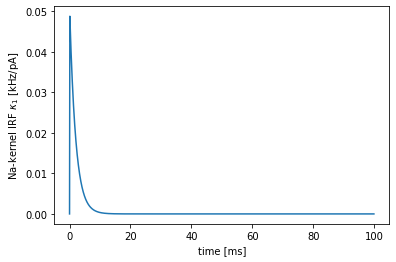

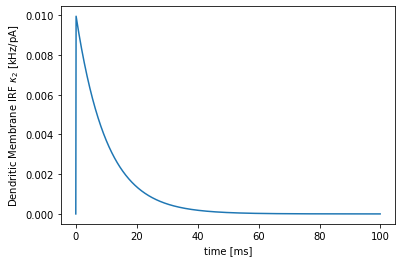

In [69]:
tauNa = 2 # filter for sodium spikes
NaFilter,tfilt = DesignExponentialFilter(pars,tauNa)
plot(tfilt,NaFilter)
xlabel('time [ms]')
ylabel('Na-kernel IRF $\kappa_1$ [kHz/pA]')

figure()
tauDmem = 10 # filter for sodium spikes
DMemFilter,tfilt = DesignExponentialFilter(pars,tauDmem)
plot(tfilt,DMemFilter)
xlabel('time [ms]')
ylabel('Dendritic Membrane IRF $\kappa_2$ [kHz/pA]')

Input Gaussian White Noise

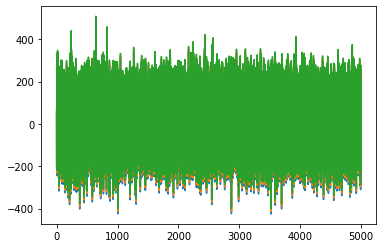

In [76]:
I = my_GWN(pars, 0, 1.0, myseed=False)
shifts = [-12,0,12]
for i in shifts:
  plot(pars['range_t'],I+i)


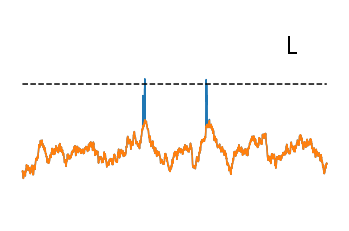

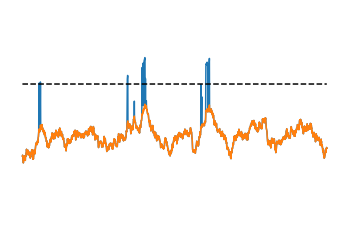

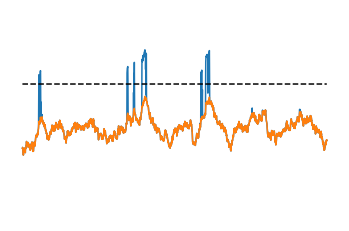

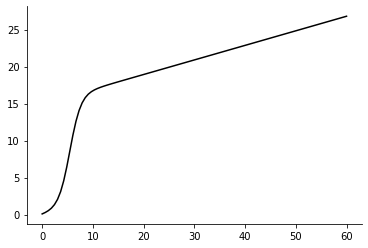

In [118]:
pars['NL_baseline'] = 5
pars['NL_sensit'] = 1
pars['NL_scale'] = 15.0
tauNa = 2 # filter for sodium spikes
NaFilter,tfilt = DesignExponentialFilter(pars,tauNa)
tauDmem = 10 # filter for sodium spikes
DMemFilter,tfilt = DesignExponentialFilter(pars,tauDmem)
shifts = [-45,-35,-30]

input = I+shifts[0]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=True)


input = I+shifts[1]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=False)

input = I+shifts[2]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=False)

plot_nlin(pars,NaFilter,DMemFilter,maxAmp=60.0,dur=50)


## Extend timescale


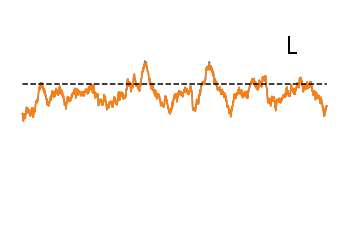

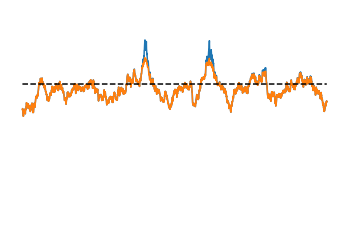

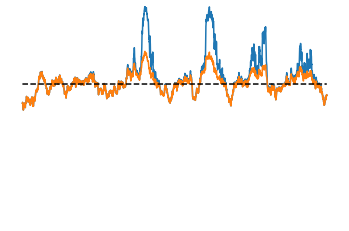

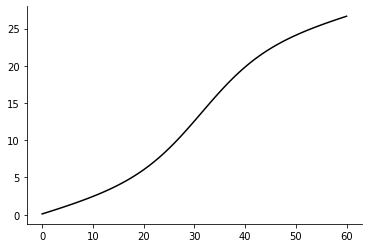

In [116]:
pars['NL_baseline'] = 5
pars['NL_sensit'] = 1
pars['NL_scale'] = 15.0
tauNa = 30 # filter for sodium spikes
NaFilter,tfilt = DesignExponentialFilter(pars,tauNa)
tauDmem = 10 # filter for sodium spikes
DMemFilter,tfilt = DesignExponentialFilter(pars,tauDmem)
shifts = [-8,-5,-1]


input = I+shifts[0]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=True)


input = I+shifts[1]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=False)

input = I+shifts[2]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=False)

plot_nlin(pars,NaFilter,DMemFilter,maxAmp=60.0,dur=50)

## Extend sensitivity


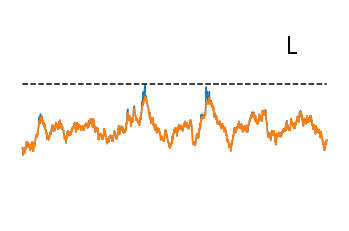

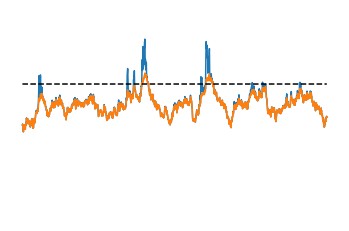

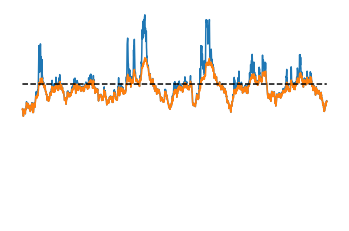

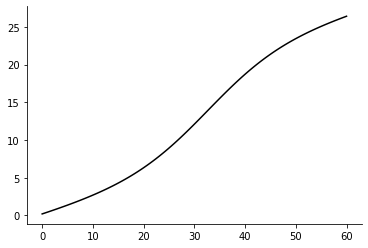

In [122]:
pars['NL_baseline'] = 30
pars['NL_sensit'] = 7
pars['NL_scale'] = 15.0
tauNa = 2 # filter for sodium spikes
NaFilter,tfilt = DesignExponentialFilter(pars,tauNa)
tauDmem = 10 # filter for sodium spikes
DMemFilter,tfilt = DesignExponentialFilter(pars,tauDmem)
shifts = [-12,0,12]

shifts = [-30,-15,-5]

input = I+shifts[0]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=True)


input = I+shifts[1]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=False)

input = I+shifts[2]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=False)

plot_nlin(pars,NaFilter,DMemFilter,maxAmp=60.0,dur=50)

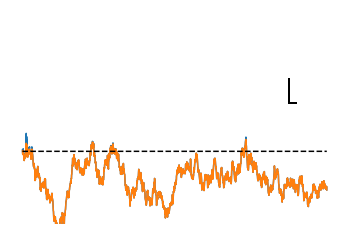

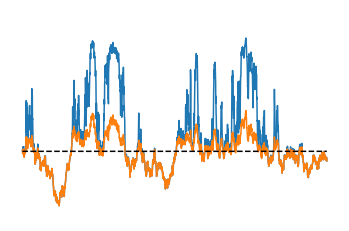

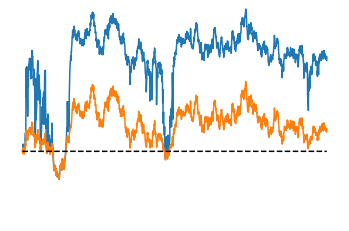

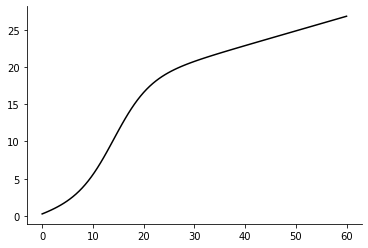

In [44]:
pars['NL_baseline'] = 4
pars['NL_sensit'] = 1
pars['NL_scale'] = 15.0
tauNa = 15 # filter for sodium spikes
NaFilter,tfilt = DesignExponentialFilter(pars,tauNa)
tauDmem = 10 # filter for sodium spikes
DMemFilter,tfilt = DesignExponentialFilter(pars,tauDmem)
shifts = [-5,0,5]

shifts = [-12,0,12]

input = I+shifts[0]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=True)


input = I+shifts[1]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=False)

input = I+shifts[2]
Vd,VL,INa_pre = computeLNL(pars,NaFilter,DMemFilter,input)
plot_trace(pars,Vd,VL,scalebar=False)

plot_nlin(pars,NaFilter,DMemFilter,maxAmp=60.0,dur=50)